In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math
import random
from sklearn.utils import resample
from sklearn.externals import joblib
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score
import xgboost

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# IMPORT DATA

In [2]:
#import Pickled Data

X_train = pickle.load(open("X_train_features.pkl", 'rb'))
y_train = pickle.load(open("y_train_features.pkl", 'rb'))
X_validation = pickle.load(open("X_validation_features.pkl", 'rb'))
y_validation = pickle.load(open("y_validation_features.pkl", 'rb'))
X_test = pickle.load(open("X_test_features.pkl", 'rb'))



X_train_pay = pickle.load(open("X_train_pay.pkl", 'rb'))

Lin_features = pickle.load(open('bestFeatures.pkl', 'rb'))


In [3]:
#import unprocessed original data

traindf = pd.read_csv("train.csv")
validationdf = pd.read_csv("validation.csv")
testdf = pd.read_csv("test.csv")


In [4]:
#Liimit the input data by the feature columns

feature_X_train = X_train[Lin_features].values
feature_X_val = X_validation[Lin_features].values
feature_X_test = X_test[Lin_features].values

#print(len(X_validation.columns))

In [25]:
'''
Creating the necessary variables for the the average CTR 
and the range which will be used to test the base bid
'''
avgCTR = traindf["click"].sum()*100/traindf.shape[0]
bid_list = range(100,150, 5)


avgBid_training = traindf.loc[traindf["click"] == 1, "payprice"].mean()
print("In the training data, the average CTR is: %.4f , and the average BID is: $%.2f"
      % (avgCTR, avgBid_training))


In the training data, the average CTR is: 0.0738 , and the average BID is: $105.46


# XGB

In [29]:

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', colsample_bytree = 0.2, learning_rate = 0.1,
               max_depth = 5, alpha = 10, n_estimators = 500, random_state = 123)

xgb_clf.fit(feature_X_train, y_train)


predict_proba_list_val = xgb_clf.predict_proba(feature_X_val)

predict_proba_list_test = xgb_clf.predict_proba(feature_X_test)

validationdf['click_proba_xgb'] = [item[1] for item in predict_proba_list_val]
testdf['click_proba_xgb'] = [item[1] for item in predict_proba_list_test]

In [13]:
'''
Linear bidding which bids on each row based on the mulipication of the base bid 
by the row's likeliness of getting a click, divided by the avg CTR'''


def lin_bid(base_bid, df, budget = 6250000):
    
    bid = (base_bid * df["click_proba_xgb"]) / avgCTR
        
    counter = 0
    clicks = 0
    imp = 0
    spent = 0
    
    while ((budget >= 0) & (counter < len(df))):

        if(df['payprice'][counter] < bid[counter]):
            budget -= df['payprice'][counter]
            spent += df["payprice"][counter]
            clicks += df['click'][counter]
            imp += 1
            
        counter += 1
        
    ctr = clicks/imp
    cpm = spent/imp
    cpc = spent/clicks/1000
    spent = round(spent/6250000 *100)
    
    
    return clicks, ctr, spent, cpm, cpc, imp, bid

In [14]:
def run_lin_bid_model(df):
    clicks_list = []
    imp_list = []

    for bid in bid_list:

        clicks, ctr, spent, cpm, cpc, imp, bids = lin_bid(bid, df)
        print("Bidding $ %s scores:: %s clicks, %.5f ctr, %s spent, %.2f cpm, %.2f cpc, %s imp"  
              % (bid, clicks, ctr, spent, cpm, cpc, imp))
        clicks_list.append(clicks)
        imp_list.append(imp)  

    plt.figure(figsize = (10,8))

    plt.subplot(3,1,1)
    plt.plot(bid_list, imp_list, "b-" )
    plt.xlabel("Base Bid")
    plt.ylabel("# of Impressions")
    plt.show()

    plt.figure(figsize = (10,8))

    plt.subplot(3,1,1)
    plt.plot(bid_list, clicks_list, "r")

    plt.xlabel("Base Bid")
    plt.ylabel("# of Clicks")
    plt.show()

# PREDICT THE VALIDATION DATAFRAME

Bidding $ 100 scores:: 157 clicks, 0.00135 ctr, 84.0 spent, 45.53 cpm, 33.61 cpc, 115878 imp
Bidding $ 105 scores:: 161 clicks, 0.00134 ctr, 89.0 spent, 46.30 cpm, 34.66 cpc, 120521 imp
Bidding $ 110 scores:: 161 clicks, 0.00129 ctr, 94.0 spent, 47.03 cpm, 36.51 cpc, 124992 imp
Bidding $ 115 scores:: 162 clicks, 0.00125 ctr, 99.0 spent, 47.73 cpm, 38.10 cpc, 129322 imp
Bidding $ 120 scores:: 155 clicks, 0.00120 ctr, 100.0 spent, 48.34 cpm, 40.32 cpc, 129283 imp
Bidding $ 125 scores:: 145 clicks, 0.00114 ctr, 100.0 spent, 48.95 cpm, 43.10 cpc, 127675 imp
Bidding $ 130 scores:: 142 clicks, 0.00113 ctr, 100.0 spent, 49.54 cpm, 44.01 cpc, 126172 imp
Bidding $ 135 scores:: 140 clicks, 0.00112 ctr, 100.0 spent, 50.15 cpm, 44.64 cpc, 124625 imp
Bidding $ 140 scores:: 135 clicks, 0.00110 ctr, 100.0 spent, 50.73 cpm, 46.30 cpc, 123198 imp
Bidding $ 145 scores:: 133 clicks, 0.00109 ctr, 100.0 spent, 51.23 cpm, 46.99 cpc, 121999 imp


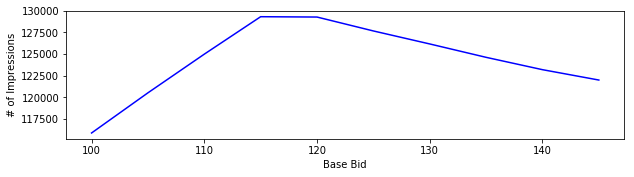

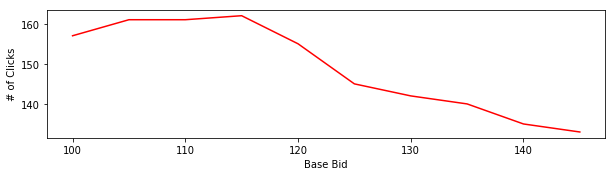

In [30]:
run_lin_bid_model(validationdf)

In [33]:
bid = 115
clicks, ctr, spent, cpm, cpc, imp, bids = lin_bid(bid, validationdf)
print("THE BEST BID IS")
print("Bidding $ %s scores:: %s clicks, %.5f ctr, %s spent, %.2f cpm, %.2f cpc, %s imp"  
      % (bid, clicks, ctr, spent, cpm, cpc, imp))


THE BEST BID IS
Bidding $ 115 scores:: 162 clicks, 0.00125 ctr, 99.0 spent, 47.73 cpm, 38.10 cpc, 129322 imp


# LEADERBOARD BIDS

In [34]:
#Will output the csv which will be used for the leaderboard website
l_bid = 115
testdf['bidprice'] = round((l_bid * testdf["click_proba_xgb"]) / avgCTR)


leaderboard_output = testdf[['bidid','bidprice']]

#DETERMINE HOW TO SORT
#leaderboard_output = leaderboard_output.sort_values(by='bidprice', ascending=False)
leaderboard_output.to_csv("testing bidding price.csv", index=False)

leaderboard_output.head(10)

,bidid,bidprice
224409,d050d7edff07a5b662957044c4b1bd70616d452e,1558.0
63890,9459958149b5a60a9e597a143be0ea49f2c13eea,1558.0
216364,bff90bfd980eec7478bc24b1724e2d0f94e39a86,1558.0
238648,df2f7f700fe1d3c5b00b6d3f662408ad16bc4598,1558.0
165726,f27dad6f9b4b604a77c7940ae3bd92fc24cf7b85,1557.0
282799,c7316cea40be46d0ff6a660da5135428c041e219,1556.0
121051,0246d64b49fa8269ce10e4f46b767e6968d8b381,1555.0
223866,e81cf8b7328118ace54c3cd40fb34b79f2c7aa8a,1554.0
170850,1e5438ffc4739b102676cdf667eb659c42530351,1552.0
202026,91c2b30a1642bd86c3d9cbd947cd6de514e87a33,1552.0
